In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
import text2synth

import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

In [140]:
# Constants
F0 = 344.0  # fundamental frequency
DURATION = 1.1  # [seconds]
SAMPLE_RATE = 16_000  # [Hz]
NUM_FRAMES = int(DURATION * SAMPLE_RATE)

# Sample frequency inputs
F0_FULL = torch.full((1, NUM_FRAMES), F0, dtype=torch.float64, requires_grad=True)

def plot(freq, waveform, sample_rate, zoom=False, vol=0.1):
    """
    Plot frequency, waveform, and spectrogram information (as well as audio playback).
    Args:
        freq: Tensor of shape (time), in Hz.
        waveform: Tensor of shape (time) in amplitude (?).
        sample_rate: Float in Hz.
        zoom: Boolean to display "zoomed" in waveform.
        vol: Float [0,1] (WARNING: keep low, gets loud).
    """
    freq = freq.detach()
    waveform = waveform.detach()
    t = (torch.arange(waveform.size(0)) / sample_rate).numpy()

    fig, axes = plt.subplots(3, 1, sharex=True)
    axes[0].plot(t, freq.numpy())
    axes[0].set(title="Waveform", ylabel="Frequency [Hz]", ylim=[-0.03, None])
    axes[1].plot(t, waveform)
    axes[1].set(ylabel="Waveform")
    axes[2].specgram(waveform, Fs=sample_rate)
    axes[2].set(ylabel="Spectrogram", xlabel="Time [s]", xlim=[-0.01, t[-1] + 0.01])

    for i in range(3):
        axes[i].grid(True)
    pos = axes[2].get_position()
    fig.tight_layout()

    if zoom:
        ax = fig.add_axes([pos.x0 + 0.02, pos.y0 + 0.32, pos.width / 2.5, pos.height / 2.0])
        ax.plot(t, waveform)
        ax.set(xlim=(1 / F0, 3 / F0), xticks=[], yticks=[])

    waveform /= waveform.abs().max()
    return ipd.Audio(vol * waveform, rate=sample_rate, normalize=False)

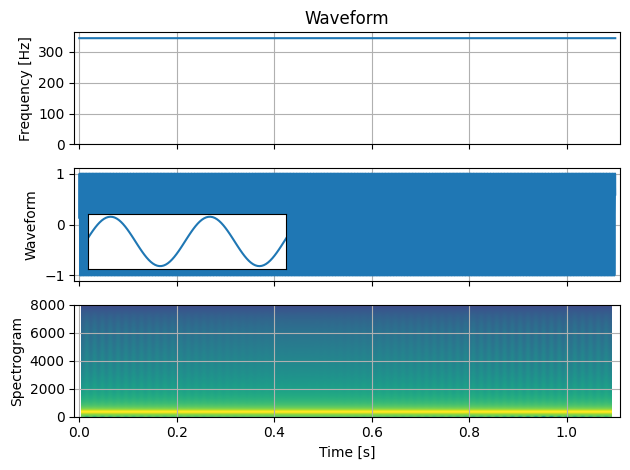

In [141]:
# Sinusoidal Oscillator
sin_osc = text2synth.SinOscillator(SAMPLE_RATE)
plot(F0_FULL[0], sin_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

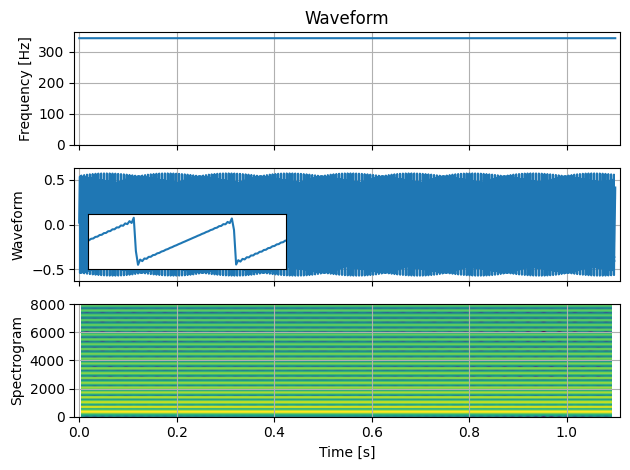

In [142]:
saw_osc = text2synth.SawtoothOscillator(SAMPLE_RATE, int(SAMPLE_RATE / F0))
plot(F0_FULL[0], saw_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

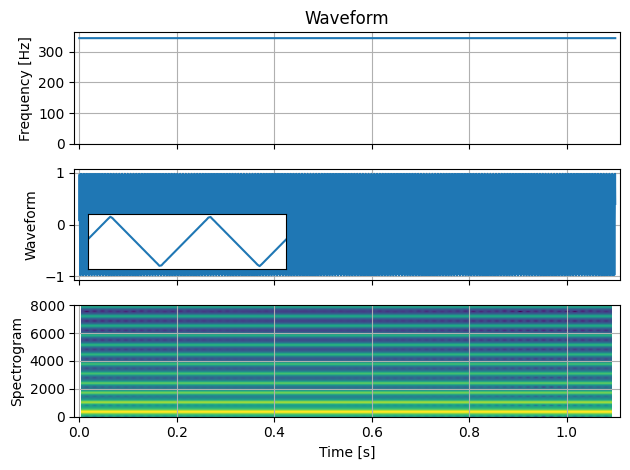

In [143]:
tri_osc = text2synth.TriangleOscillator(SAMPLE_RATE, int(SAMPLE_RATE / F0))
plot(F0_FULL[0], tri_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

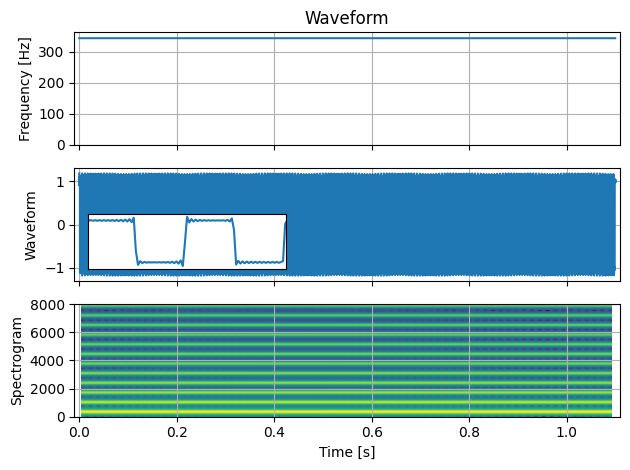

In [144]:
sq_osc = text2synth.SquareOscillator(SAMPLE_RATE, int(SAMPLE_RATE / F0))
plot(F0_FULL[0], sq_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

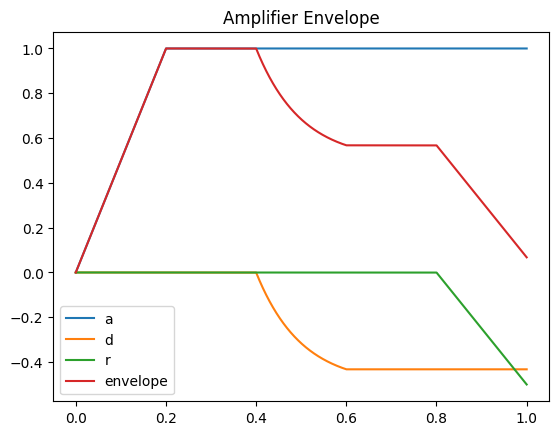

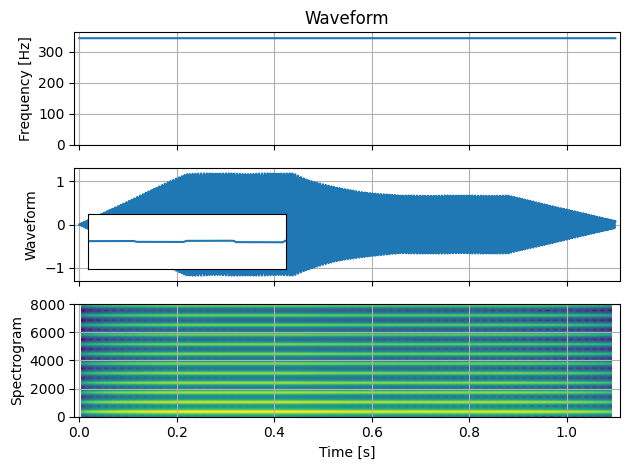

In [145]:
amp_env = text2synth.AmpEnvelope(2)
amp_params = {
    'a': torch.tensor(0.2, requires_grad = True),
    'h': torch.tensor(0.2, requires_grad = True),
    'd':torch.tensor(0.2, requires_grad = True),
    's':torch.tensor(0.5, requires_grad = True),
    'r':torch.tensor(0.2, requires_grad = True)
}

plot(F0_FULL[0], amp_env(sq_osc(F0_FULL), amp_params)[0], SAMPLE_RATE, zoom=True)

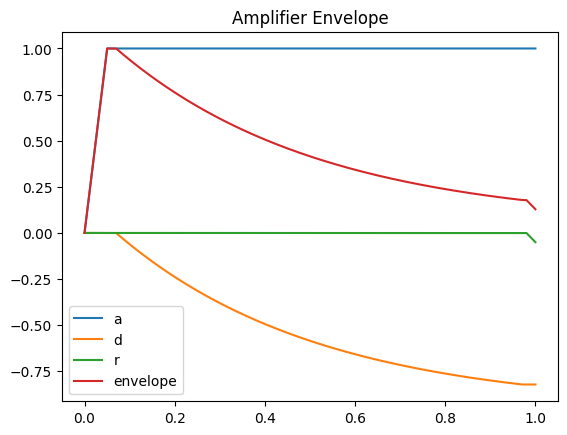

tensor([[-3.9625e-08, -3.9625e-08, -3.9601e-08,  ...,  2.5163e-09,
          8.3489e-10,  3.1666e-09]], dtype=torch.float64)
a: 0.2765465974807739
h: 0.954851508140564
d: 0.2295190840959549
s: 0.36998122930526733
r: -0.006793667562305927


In [146]:
# Backwards
F0_FULL = torch.full((1, NUM_FRAMES), F0, dtype=torch.float64, requires_grad=True)
amp_params = {
    'a': torch.tensor(0.05, requires_grad = True),
    'h': torch.tensor(0.02, requires_grad = True),
    'd':torch.tensor(0.9, requires_grad = True),
    's':torch.tensor(0.05, requires_grad = True),
    'r':torch.tensor(0.02, requires_grad = True)
}
# Phase increment per timestep
output = amp_env(sq_osc(F0_FULL), amp_params)
target = torch.ones_like(output)  # Example target (e.g., target waveform)
loss = torch.mean((output - target) ** 2)  # Loss (e.g., MSE loss)
loss.backward()
print(F0_FULL.grad)
for k,v in amp_params.items():
    print("{}: {}".format(k, v.grad))
